In [1]:
from __future__ import division

import base64
import csv
import gzip
import zlib
import numpy as np
from collections import namedtuple

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
TRACE_NUM = 1000
from importlib import reload
import logging
reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%H:%M:%S')

def trace(items_num, trace_num=TRACE_NUM):
    if items_num % trace_num == 0: logging.info("Complete items %05d" % items_num)

In [3]:
from html.parser import HTMLParser
#from HTMLParser import HTMLParser
import re

###Извлечение текста из title можно вписать сюда


In [18]:
a = [np.nan, np.nan, np.nan]
if not np.isnan(a).all():
    print('***')

In [55]:
def html2text_bs(raw_html):
    from bs4 import BeautifulSoup
    soup = BeautifulSoup(raw_html, "html.parser")
    [s.extract() for s in soup(['script', 'style'])]
    text = soup.get_text()
    
    soup = BeautifulSoup(raw_html, "html.parser")
    [s.extract() for s in soup(['style', 'script', '[document]', 'head', 'title'])]
    visible_text = soup.get_text()
    
    soup = BeautifulSoup(raw_html, "html.parser")
    titles = list()
    find = soup.find('title')
    title_len = 0
    if find != None:
        for title in soup.find('title'):
            title = title.string
            if title != None:
                titles.append(len(title.strip().split()))
        if len(titles) != 0 and not np.isnan(titles).all():
            title_len = np.nanmean(titles) 
    
    len_anchor = list()
    avg_anchor_len = 0
    for links in soup.findAll('a'):
        anchor = links.string
        if anchor != None:
            len_anchor.append(len(anchor.strip().split()))
    anchor_num = len(len_anchor)
    if anchor_num != 0 and not np.isnan(len_anchor).all():
        avg_anchor_len = np.nanmean(len_anchor)
  
    '''    
    len_meta_descr = list()
    avg_meta_descr_len = 0
    for meta in soup.findAll('meta', {'name':'description'}):
        meta = meta.get('content')
        if meta != None:
            len_meta_descr.append(len(meta.strip().split()))
    if len(len_meta_descr) != 0 and not np.isnan(len_meta_descr).all():
        avg_meta_descr_len = np.nanmean(len_meta_descr)
'''
    
    
    '''len_meta_keywords = list()
    avg_meta_keywords_len = 0
    for meta in soup.findAll('meta', {'name':'keywords'}):
        meta = meta.get('content')
        if meta != None:
            len_meta_keywords.append(len(meta.strip().split()))
    if len(len_meta_descr) != 0 and not np.isnan(len_meta_keywords).all():
        avg_meta_keywords_len = np.nanmean(len_meta_keywords)'''
            
    log_phis_tags = len(soup(['b', 'i', 'u', 'strike', 's', 'tt', 'small', 'big',
                              'sup', 'sub', 'p', 'font', 'pre', 'abbr', 'acronym',
                              'address', 'cite', 'code', 'del', 'dfn', 'ins', 'em',
                              'kbd', 'q', 'samp', 'strong', 'var']))
    
    image_num = len(soup.findAll('img'))
    
    script_num = len(soup.findAll('script'))
    
    css_num = len(soup.findAll('link'))
            
    return {'text': text,
            'visible_text': visible_text,
            'title_len': title_len,
            'avg_anchor_len': avg_anchor_len,
            'anchor_num': anchor_num,
            #'avg_meta_descr_len': avg_meta_descr_len,
            #'avg_meta_keywords_len': avg_meta_keywords_len,
            'log_phis_tags': log_phis_tags,
            'image_num': image_num,
            'script_num': script_num,
            'css_num': css_num
           }    


In [56]:
html2text = html2text_bs

In [57]:
def to_utf8(text):
    if isinstance(text, str): text = text.encode('utf8')
    return text

def convert2unicode(f):
    def tmp(text):
        if not isinstance(text, str): text = text.decode('utf8')
        return f(text)
    return tmp

def convert2lower(f):
    def tmp(text):        
        return f(text.lower())
    return tmp

In [58]:
@convert2lower
@convert2unicode
def easy_tokenizer(text):
    word = str()
    for symbol in text:
        if symbol.isalnum(): word += symbol
        elif word:
            yield word
            word = str()
    if word: yield word

PYMORPHY_CACHE = {}
MORPH = None
#hint, чтобы установка pymorphy2 не была бы обязательной
def get_lemmatizer():
    import pymorphy2
    global MORPH
    if MORPH is None: MORPH = pymorphy2.MorphAnalyzer()
    return MORPH

@convert2lower
@convert2unicode
def pymorphy_tokenizer(text):
    global PYMORPHY_CACHE
    for word in easy_tokenizer(text):
        word_hash = hash(word)
        if word_hash not in PYMORPHY_CACHE:
            PYMORPHY_CACHE[word_hash] = get_lemmatizer().parse(word)[0].normal_form            
        yield PYMORPHY_CACHE[word_hash]

In [59]:
def html2word(raw_html, to_text=html2text, tokenizer=easy_tokenizer):
    res = dict()
    for key, value in to_text(raw_html).items():
        if type(value) == list:
            res[key] = list(map((lambda x: list(tokenizer(x.lower()))), value))
        else:
            if type(value) == str: 
                res[key] = list(tokenizer(value.lower()))
            else:
                res[key] = value
    return res
    #return dict(map(lambda x: (x[0], list(tokenizer(x[1].lower()))), to_text(raw_html).items()))

In [60]:
def safe_divide(a, b):
    if a == 0: return 0.0
    elif b == 0: return 0.0
    else: return a/b

def calculate_metrics(predictions, threshold):    
    """
    Функция подсчета метрик
    Параметры
    predictions - ранки по документам
    threshold  - порог для метрик
    """
    true_positive = 0
    false_positive = 0
    true_negative = 0
    false_negative = 0
    for (url_id, mark, url, prediction) in predictions:        
        mark_predict = prediction > threshold

        if mark_predict:                     
            if mark_predict == mark: true_positive += 1
            else: false_positive += 1                    
        else:                     
            if  mark_predict == mark: true_negative += 1
            else: false_negative += 1

    class_prec  = safe_divide(true_positive, true_positive + false_positive)
    class_recall = safe_divide(true_positive, true_positive + false_negative)
        
    class_F1 = safe_divide(2 * class_prec * class_recall, class_prec + class_recall)
    
    
    not_class_prec = safe_divide(true_negative, true_negative + false_negative)
    not_class_recall = safe_divide(true_negative, true_negative + false_positive)
    
    not_class_F1 = safe_divide(2 * not_class_prec * not_class_recall, not_class_prec + not_class_recall)
    
    return ( (class_prec, class_recall, class_F1), (not_class_prec, not_class_recall, not_class_F1) )

def arange(start, stop, step):
    cur_value = start
    while True:
        if cur_value > stop: break
        yield cur_value
        cur_value += step

def plot_results(docs, min_threshold=-1, max_threshold=1, step=0.1, trace=False):
    x = []
    y_p = []
    y_n = []
    docs_predictions = classifier.predict_all(docs)
    for threshold in arange(min_threshold, max_threshold, step):
        r = calculate_metrics(docs_predictions, threshold)
        x.append(threshold)
        y_p.append(r[0])
        y_n.append(r[1])        
        if trace: 
            print ('threshold %s' % threshold)
            print ('\tclass_prec %s, class_recall %s, class_F1 %s' % r[0])
            print ('\tnot_class_prec %s, not_class_recall %s, not_class_F1 %s' % r[1])
            print ('\t\tMacroF1Mesure %s' % ((r[0][2] + r[1][2])/2))
    plot_stats(x, y_p, "Class Result")
    plot_stats(x, y_n, "Not class Result")    


def plot_stats(x, y, title):
    plt.figure(figsize=(10, 5))

    prec, = plt.plot( x, 
                     [k[0] for k in y], "r", label='Precision', 
                     linewidth=1)
    accur, = plt.plot( x, 
                      [k[1] for k in y], "b", label='Recall',
                      linewidth=1)
    f1, =    plt.plot( x, 
                      [k[2] for k in y], "g", label='F1',
                      linewidth=1)
    plt.grid(True)
    plt.legend(handles=[prec, accur, f1])
    plt.title(title)
    plt.show()

In [90]:
def calc_features(url, html_data, compression_level):
    res = html2word(html_data)
    words = res['text']
    #visible_words = res['visible_text']
    words_num = len(words)
    avg_word_len = np.nanmean([len(word) for word in words])
    #hidden_text = 100 - len(visible_words)/words_num * 100
    title_words_num = res['title_len']
    avg_anchor_len = res['avg_anchor_len']
    anchor_num = res['anchor_num'] / words_num
    #avg_meta_descr_len = res['avg_meta_descr_len']
    #avg_meta_keywords_len = res['avg_meta_keywords_len']
    log_phis_tags_num = res['log_phis_tags'] / words_num
    image_num = res['image_num'] / words_num
    script_num = res['script_num'] /  words_num
    css_num = res['css_num'] / words_num
    url_len = len(url)
    
    return [words_num, avg_word_len, title_words_num, avg_anchor_len,
            anchor_num, log_phis_tags_num, image_num, script_num, css_num,
            compression_level, url_len]

In [91]:
test_html_data = u'''
<html>
<title> Заголовок Ololo </title>
спам 1 2 3
</html>
'''
test_url = 'http://ololo'
test_features = calc_features(test_url, test_html_data, 1)
print (test_features)

[6, 3.5, 2.0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 1, 12]


In [92]:
DocItem = namedtuple('DocItem', ['doc_id', 'is_spam', 'url', 'features'])

def load_csv(input_file_name, calc_features_f):    
    """
    Загружаем данные и извлекаем на лету признаки
    Сам контент не сохраняется, чтобы уменьшить потребление памяти - чтобы
    можно было запускать даже на ноутбуках в классе
    """
    
    with gzip.open(input_file_name) if input_file_name.endswith('gz') else open(input_file_name)  as input_file:            
        headers = input_file.readline()
        
        for i, line in enumerate(input_file):
            trace(i)
            parts = line.decode().strip().split('\t')
            url_id = int(parts[0])                                        
            mark = bool(int(parts[1]))                    
            url = parts[2]
            pageInb64 = parts[3]
            html_data = base64.b64decode(pageInb64)
            compression_level = (len(pageInb64) / len(html_data) - 1.333) * 100000 - 30
            features = calc_features_f(url, html_data, compression_level)            
            yield DocItem(url_id, mark, url, features)            
                
        trace(i, 1)        

In [93]:
%%time

TRAIN_DATA_FILE  = 'kaggle_train_data_tab_new.csv.gz'

train_docs = list(load_csv(TRAIN_DATA_FILE, calc_features))

16:11:48 INFO:Complete items 00000
16:35:16 INFO:Complete items 01000
16:52:34 INFO:Complete items 02000
17:12:56 INFO:Complete items 03000
17:20:57 WARNING:Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
17:20:57 WARNING:Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
17:20:58 WARNING:Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
17:33:13 INFO:Complete items 04000
17:54:44 INFO:Complete items 05000
18:11:15 INFO:Complete items 06000
18:31:29 INFO:Complete items 07000
18:32:13 INFO:Complete items 07043


Wall time: 2h 20min 25s


In [94]:
len(train_docs)

7044

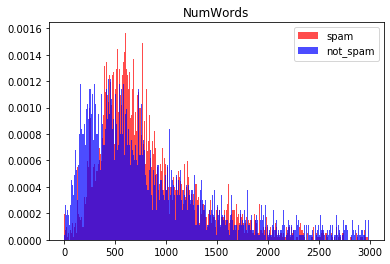

In [95]:
is_spam_data = [doc.features[0] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[0] for doc in train_docs if doc[1] == False]
bins = range(0,3000,10)
plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('NumWords')
plt.legend()
plt.show()

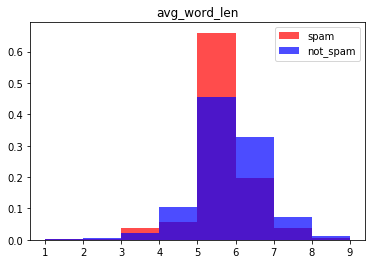

In [101]:
is_spam_data = [doc.features[1] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[1] for doc in train_docs if doc[1] == False]
bins = range(1,10,1)
plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('avg_word_len')
plt.legend()
plt.show()

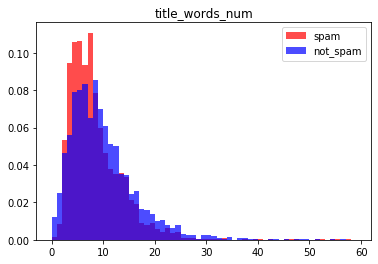

In [113]:
is_spam_data = [doc.features[2] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[2] for doc in train_docs if doc[1] == False]
bins = range(0,60,1)
plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('title_words_num')
plt.legend()
plt.show()

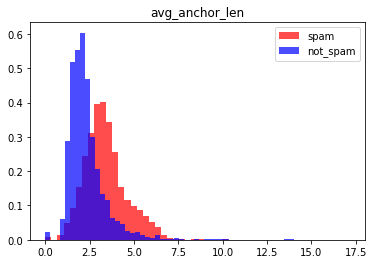

In [114]:
is_spam_data = [doc.features[3] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[3] for doc in train_docs if doc[1] == False]
plt.hist(is_spam_data, bins=50, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=50, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('avg_anchor_len')
plt.legend()
plt.show()

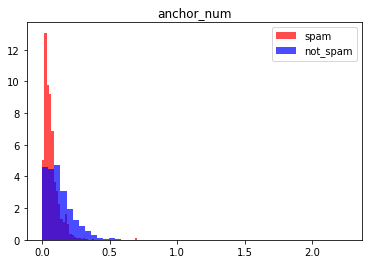

In [115]:
is_spam_data = [doc.features[4] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[4] for doc in train_docs if doc[1] == False]
plt.hist(is_spam_data, bins=50, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=50, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('anchor_num')
plt.legend()
plt.show()

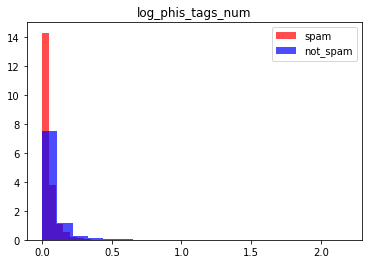

In [132]:
is_spam_data = [doc.features[5] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[5] for doc in train_docs if doc[1] == False]
plt.hist(is_spam_data, bins=20, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=20, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('log_phis_tags_num')
plt.legend()
plt.show()

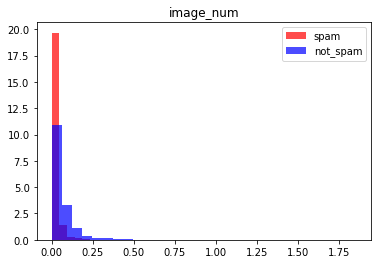

In [130]:
is_spam_data = [doc.features[6] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[6] for doc in train_docs if doc[1] == False]
plt.hist(is_spam_data, bins=30, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=30, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('image_num')
plt.legend()
plt.show()

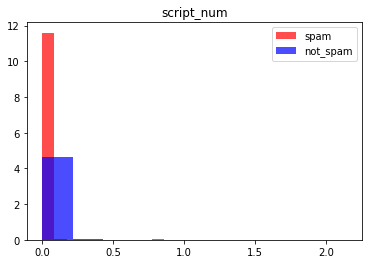

In [129]:
is_spam_data = [doc.features[7] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[7] for doc in train_docs if doc[1] == False]
plt.hist(is_spam_data, bins=10, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=10, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('script_num')
plt.legend()
plt.show()

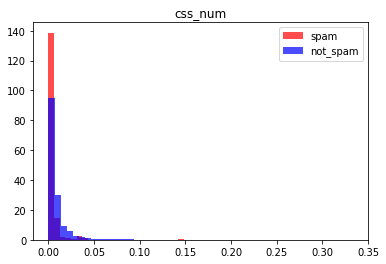

In [123]:
is_spam_data = [doc.features[8] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[8] for doc in train_docs if doc[1] == False]
plt.hist(is_spam_data, bins=50, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=50, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('css_num')
plt.legend()
plt.show()

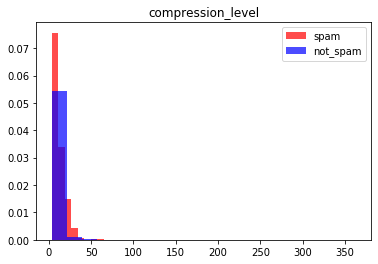

In [133]:
is_spam_data = [doc.features[9] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[9] for doc in train_docs if doc[1] == False]
plt.hist(is_spam_data, bins=20, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=20, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('compression_level')
plt.legend()
plt.show()

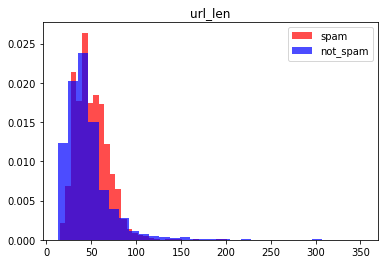

In [136]:
is_spam_data = [doc.features[10] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[10] for doc in train_docs if doc[1] == False]
plt.hist(is_spam_data, bins=30, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=30, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('url_len')
plt.legend()
plt.show()

In [171]:
#from sklearn.ensemble import GradientBoostingClassifier
from sklearn import svm

class Classifier:
    
    def __init__(self):
        #self.clf = GradientBoostingClassifier(n_estimators = 1000)
        self.clf = svm.SVC()
        
    def predict(self, doc):
        features = np.array([doc.features])
        features = np.nan_to_num(features)
        return self.clf.predict(features)                   
    
    def predict_all(self, docs):
        res = []
        for doc_num, doc in enumerate(docs):
            trace(doc_num)
            prediction = self.predict(doc)            
            res.append( (doc.doc_id, doc.is_spam, doc.url, prediction) )
        return res
    
    def train(self, docs):                
#         for doc_num, doc in enumerate(docs):                            
#             #TODO вставить код обучения
#             trace(doc_num)
#         trace(doc_num, 1)
        features = np.array([doc.features for doc in docs]).astype("float32")
        targets =  np.array([doc.is_spam for doc in docs]).astype("float32")
        features = np.nan_to_num(features)
        targets = np.nan_to_num(targets)

        self.clf = self.clf.fit(features, targets)

In [172]:
classifier = Classifier()
classifier.train(train_docs)

C:\Users\karry\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [173]:
classifier.predict(DocItem(0, 0, test_url , test_features))

array([1.], dtype=float32)

23:00:29 INFO:Complete items 00000
23:00:30 INFO:Complete items 01000
23:00:31 INFO:Complete items 02000
23:00:31 INFO:Complete items 03000
23:00:32 INFO:Complete items 04000
23:00:33 INFO:Complete items 05000
23:00:34 INFO:Complete items 06000
23:00:35 INFO:Complete items 07000


threshold 0
	class_prec 0.9958797867183713, class_recall 1.0, class_F1 0.9979356405585914
	not_class_prec 1.0, not_class_recall 0.9942078364565587, not_class_F1 0.9970955065778233
		MacroF1Mesure 0.9975155735682073
threshold 0.1
	class_prec 0.9958797867183713, class_recall 1.0, class_F1 0.9979356405585914
	not_class_prec 1.0, not_class_recall 0.9942078364565587, not_class_F1 0.9970955065778233
		MacroF1Mesure 0.9975155735682073
threshold 0.2
	class_prec 0.9958797867183713, class_recall 1.0, class_F1 0.9979356405585914
	not_class_prec 1.0, not_class_recall 0.9942078364565587, not_class_F1 0.9970955065778233
		MacroF1Mesure 0.9975155735682073
threshold 0.30000000000000004
	class_prec 0.9958797867183713, class_recall 1.0, class_F1 0.9979356405585914
	not_class_prec 1.0, not_class_recall 0.9942078364565587, not_class_F1 0.9970955065778233
		MacroF1Mesure 0.9975155735682073
threshold 0.4
	class_prec 0.9958797867183713, class_recall 1.0, class_F1 0.9979356405585914
	not_class_prec 1.0, not_c

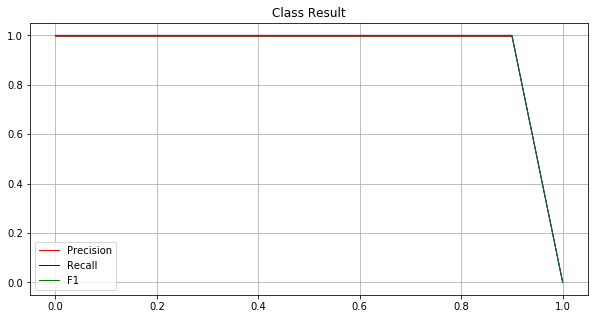

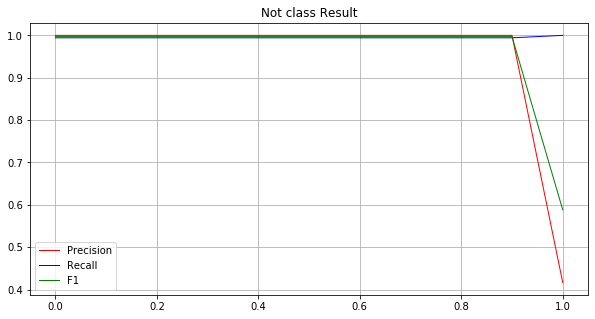

In [174]:
plot_results(train_docs, min_threshold=0, max_threshold=1, step=0.1, trace=1)

In [175]:
TEST_DATA_FILE  = 'kaggle_test_data_tab_new.csv.gz'

test_docs = load_csv(TEST_DATA_FILE, calc_features)

threshold = 0.5

with open('my_submission_new.csv' , 'w') as fout:
    writer = csv.writer(fout)
    writer.writerow(['Id','Prediction'])
    for item in classifier.predict_all(test_docs):
        prediction =  1 if item[3] > threshold else 0
        writer.writerow([item[0], prediction])

23:00:39 INFO:Complete items 00000
23:00:40 INFO:Complete items 00000
23:30:45 INFO:Complete items 01000
23:30:45 INFO:Complete items 01000
23:55:37 INFO:Complete items 02000
23:55:38 INFO:Complete items 02000
00:16:51 INFO:Complete items 03000
00:16:53 INFO:Complete items 03000
00:35:31 INFO:Complete items 04000
00:35:33 INFO:Complete items 04000
00:51:55 INFO:Complete items 05000
00:51:56 INFO:Complete items 05000
01:15:52 INFO:Complete items 06000
01:15:53 INFO:Complete items 06000
01:32:36 INFO:Complete items 07000
01:32:37 INFO:Complete items 07000
01:52:23 INFO:Complete items 08000
01:52:24 INFO:Complete items 08000
02:10:39 INFO:Complete items 09000
02:10:39 INFO:Complete items 09000
02:36:45 INFO:Complete items 10000
02:36:45 INFO:Complete items 10000
02:55:01 INFO:Complete items 11000
02:55:01 INFO:Complete items 11000
03:14:50 INFO:Complete items 12000
03:14:50 INFO:Complete items 12000
03:31:26 INFO:Complete items 13000
03:31:27 INFO:Complete items 13000
03:52:23 INFO:Comple